In [112]:
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec

from gensim.models import Doc2Vec
from scipy.spatial import distance
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence

import itertools
import xgboost as xgb
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.spatial import distance
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import accuracy_score

from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1)

# Load and clean data

In [2]:
data = pd.read_csv("/Users/eulalieformery/Desktop/Datacamp/Kickstarter_light.csv")
data = data.dropna(subset=['name','short_description'])

In [3]:
#create binary label = 1 -> has reached the goal 0 -> did not reach it
data['Target'] = np.where( data['pledged']>=data['goal'], 1, 0)


In [4]:
data.index = np.arange(0, len(data))

In [5]:
data.columns

Index(['Unnamed: 0', 'id', 'name', 'short_description', 'country', 'city',
       'state_location', 'main_category', 'category', 'created_at',
       'launched_at', 'state_changed_at', 'deadline', 'currency', 'country.1',
       'creator_name', 'creator_id', 'project_we_love', 'image_available',
       'description_available', 'goal', 'pledged', 'achieved (%)',
       'usd_pledged', 'static_usd_rate', 'usd_type', 'state', 'Target'],
      dtype='object')

In [54]:
mask1 = ( data['achieved (%)']< 120)&( data['achieved (%)']>=100)
mask2 = ( data['achieved (%)']< 100)
mask3 = ( data['achieved (%)']>= 120)

data['success'] = data['achieved (%)'].mask(mask3, 2)
data['success'] = data['achieved (%)'].mask(mask2, 1)
data['success'] = data['achieved (%)'].mask(mask2, 0)

In [58]:
data['success'] = np.where((data['achieved (%)'] < 120)&( data['achieved (%)']>=100), 1, np.where(data['achieved (%)']>= 120, 2, 0))

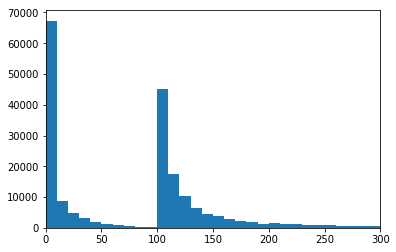

In [37]:
plt.xlim((0,300))
plt.hist(data['achieved (%)'], bins=1000, range=(0,10000))
plt.show()

# Create features

From Date

In [82]:
data['launched_date'] = pd.to_datetime(data['created_at'], format='%Y-%m-%d %H:%M:%S')
data['deadline_date'] = pd.to_datetime(data['deadline'], format='%Y-%m-%d %H:%M:%S')

In [83]:
#length of project
data['length'] = data['deadline_date'] - data['launched_date']
data['length'] = [d.days for d in data['length']]

In [84]:
#features with month and year of launch
data['year'] = [d.year for d in data['launched_date']]
data['month'] = [d.month for d in data['launched_date']]
data['day'] = [d.day for d in data['launched_date']]

 From name

In [85]:
#length of name
data['name_length'] = [len(name) for name in data['name']]

#number of words
data['word_number'] = [len(name.split(' ')) for name in data['name']]
    
#ponctuation
data['question'] = (data.name.str[-1] == '?').astype(int)
data['exclamation'] = (data.name.str[-1] == '!').astype(int)

#upper
data['uppercase'] = data.name.str.isupper().astype(float)

In [70]:
data.columns

Index(['Unnamed: 0', 'id', 'name', 'short_description', 'country', 'city',
       'state_location', 'main_category', 'category', 'created_at',
       'launched_at', 'state_changed_at', 'deadline', 'currency', 'country.1',
       'creator_name', 'creator_id', 'project_we_love', 'image_available',
       'description_available', 'goal', 'pledged', 'achieved (%)',
       'usd_pledged', 'static_usd_rate', 'usd_type', 'state'],
      dtype='object')

In [86]:
#create dummies for categorical features
main_category = pd.get_dummies(data['main_category'],prefix='mc')
category = pd.get_dummies(data['category'], prefix = 'cat')
country = pd.get_dummies(data['country'], prefix = 'country')
#country = pd.get_dummies(data['city'], prefix = 'city')

currency = pd.get_dummies(data['currency'], prefix = 'currency')


data_modified = pd.concat([data, main_category, category, country, currency], axis=1)

Features to drop before classification:

    
    'Unnamed: 0', 'id', 'name', 'short_description', 'country', 'city',
       'state_location', 'main_category', 'category', 'created_at',
       'launched_at', 'state_changed_at', 'deadline', 'currency', 'country.1',
       'creator_name', 'creator_id', 'project_we_love', 'goal', 'pledged', 'achieved (%)',
       'usd_pledged', 'static_usd_rate', 'usd_type', 'state'

In [95]:
data.description_available = data.description_available.astype(int)
data.image_available = data.image_available.astype(int)

# Word2vec embeddings on names and decriptions

In [64]:
names = data['name']

In [66]:
# remove dashes and apostrophes from punctuation marks 
punct = string.punctuation.replace('-', '').replace("'",'')
# regex to match intra-word dashes and intra-word apostrophes
my_regex = re.compile(r"(\b[-']\b)|[\W_]")

def clean_string(string, punct=punct, my_regex=my_regex, to_lower=False):
    if to_lower:
        string = string.lower()
    # remove formatting
    str = re.sub('\s+', ' ', string)
     # remove punctuation
    str = ''.join(l for l in str if l not in punct)
    # remove dashes that are not intra-word
    str = my_regex.sub(lambda x: (x.group(1) if x.group(1) else ' '), str)
    # strip extra white space
    str = re.sub(' +',' ',str)
    # strip leading and trailing white space
    str = str.strip()
    return str

In [73]:
cleaned_names = []
for idx, doc in enumerate(names):
    # clean
    doc = clean_string(doc, punct, my_regex, to_lower=True)
    # tokenize (split based on whitespace)
    tokens = doc.split(' ')

    # remove digits
    tokens = [''.join([elt for elt in token if not elt.isdigit()]) for token in tokens]
    # remove tokens shorter than 3 characters in size
    tokens = [token for token in tokens if len(token)>2]
    # remove tokens exceeding 25 characters in size
    tokens = [token for token in tokens if len(token)<=25]
    cleaned_names.append(tokens)
    

In [68]:
description = data['short_description']

In [69]:
cleaned_description = []
for idx, doc in enumerate(description):
    # clean
    doc = clean_string(doc, punct, my_regex, to_lower=True)
    # tokenize (split based on whitespace)
    tokens = doc.split(' ')

    # remove digits
    tokens = [''.join([elt for elt in token if not elt.isdigit()]) for token in tokens]
    # remove tokens shorter than 3 characters in size
    tokens = [token for token in tokens if len(token)>3]
    # remove tokens exceeding 25 characters in size
    tokens = [token for token in tokens if len(token)<=25]
    cleaned_description.append(tokens)
    

In [70]:
cleaned_total = cleaned_names.copy()

for a in cleaned_description:
    cleaned_total.append(a)

**Train Word2vec Model**

In [71]:
%%time 

model = Word2Vec(cleaned_total, min_count=1, size=100, workers=8)

CPU times: user 1min 9s, sys: 902 ms, total: 1min 10s
Wall time: 32.1 s


In [72]:
print('Vocab size: %d' %len(model.wv.vocab))

Vocab size: 173735


In [75]:
name_matrix = np.zeros((len(cleaned_names),100),dtype="float32")

for i in range(len(cleaned_names)):
    try:
        name_matrix[i,]=model.wv[cleaned_names[i]].sum(0)/len(cleaned_names[i]) 
    except:
        #print(cleaned_project_names[i])
        name_matrix[i,]=np.zeros((1,100),dtype="float32")
        #print(name_matrix[i,])
               


In [76]:
description_matrix = np.zeros((len(cleaned_description),100),dtype="float32")

for i in range(len(cleaned_description)):
    try:
        description_matrix[i,]=model.wv[cleaned_description[i]].sum(0)/len(cleaned_description[i]) 
    except:
        #print(cleaned_project_names[i])
        description_matrix[i,]=np.zeros((1,100),dtype="float32")
        #print(name_matrix[i,])


In [91]:
name_embeddings = pd.DataFrame(name_matrix)
name_embeddings = name_embeddings.add_prefix('name_')
description_embeddings = pd.DataFrame(description_matrix)
description_embeddings = description_embeddings.add_prefix('desc_')

# Binary classification

In [99]:
y = data['Target']
X = data[data.columns.difference(['Unnamed: 0', 'id', 'name', 'short_description', 'country', 'city',
       'state_location', 'main_category', 'category', 'created_at',
       'launched_at', 'state_changed_at', 'deadline', 'currency', 'country.1',
       'creator_name', 'creator_id', 'project_we_love', 'goal', 'pledged', 'achieved (%)',
       'usd_pledged','launched_date','deadline_date', 'static_usd_rate', 'usd_type', 'success','state','Target'])]

X = pd.concat([X, name_embeddings], axis = 1)
X = pd.concat([X, description_embeddings], axis = 1)


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## XGBoost

In [101]:
xgboost_model = xgb.XGBRegressor(booster = 'gbtree',objective = 'binary:logistic', colsample_bytree = 0.9, learning_rate = 0.1,
                max_depth = 5, alpha =10, n_estimators = 50 , eval_metric = 'auc')

In [102]:
xgboost_model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Results with word2vec on names and description

In [104]:
y_pred = xgboost_model.predict(X_test)

print('accuracy', accuracy_score(y_test, [1 if a>0.5 else 0 for a in y_pred]))
print('log_loss',log_loss(y_test, y_pred))
print('roc',roc_auc_score(y_test, y_pred))
print('f1 Score',f1_score(y_test, [1 if a>0.5 else 0 for a in y_pred]))
print('precision', precision_score(y_test, [1 if a>0.5 else 0 for a in y_pred]))
print('recall', recall_score(y_test,[1 if a>0.5 else 0 for a in y_pred]))
print(confusion_matrix(y_test, [1 if a>0.5 else 0 for a in y_pred]))

accuracy 0.6682752771197099
log_loss 0.6100587349177791
roc 0.7163271399187193
f1 Score 0.7351979828165857
precision 0.6721881870770807
recall 0.8112424968441662
[[14208 15357]
 [ 7327 31490]]


Results with word2vec on description

In [122]:
y_pred = xgboost_model.predict(X_test)

print('accuracy', accuracy_score(y_test, [1 if a>0.5 else 0 for a in y_pred]))
print('log_loss',log_loss(y_test, y_pred))
print('roc',roc_auc_score(y_test, y_pred))
print('f1 Score',f1_score(y_test, [1 if a>0.5 else 0 for a in y_pred]))
print('precision', precision_score(y_test, [1 if a>0.5 else 0 for a in y_pred]))
print('recall', recall_score(y_test,[1 if a>0.5 else 0 for a in y_pred]))
print(confusion_matrix(y_test, [1 if a>0.5 else 0 for a in y_pred]))

accuracy 0.6925652949606622
log_loss 0.5847909801446575
roc 0.7515372110726051
f1 Score 0.7334711005743119
precision 0.72209186220669
recall 0.7452147255068655
[[18432 11133]
 [ 9890 28927]]


**Results with generated word2vec embeddings**

In [366]:
y_pred = xgboost_model.predict(X_test)

print('accuracy', accuracy_score(y_test, [1 if a>0.5 else 0 for a in y_pred]))
print('log_loss',log_loss(y_test, y_pred))
print('roc',roc_auc_score(y_test, y_pred))
print('f1 Score',f1_score(y_test, [1 if a>0.5 else 0 for a in y_pred]))
print('precision', precision_score(y_test, [1 if a>0.5 else 0 for a in y_pred]))
print('recall', recall_score(y_test,[1 if a>0.5 else 0 for a in y_pred]))

accuracy 0.7015213233352273
log_loss 0.5652065911418699
roc 0.7511580264024725
f1 Score 0.4769077572544564
precision 0.6572345278132127
recall 0.37422961789047365


# Multiclass Classification

In [105]:
y = data['success']
X = data[data.columns.difference(['Unnamed: 0', 'id', 'name', 'short_description', 'country', 'city',
       'state_location', 'main_category', 'category', 'created_at',
       'launched_at', 'state_changed_at', 'deadline', 'currency', 'country.1',
       'creator_name', 'creator_id', 'project_we_love', 'goal', 'pledged', 'achieved (%)',
       'usd_pledged','launched_date','deadline_date', 'static_usd_rate', 'usd_type', 'success','state','Target'])]

X = pd.concat([X, name_embeddings], axis = 1)
X = pd.concat([X, description_embeddings], axis = 1)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [108]:
xgb_clas = xgb.XGBClassifier(booster = 'gbtree',objective = 'multi:softmax', colsample_bytree = 0.9, learning_rate = 0.1,
                max_depth = 5, alpha =10, n_estimators = 50)

xgb_clas.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [110]:
y_predict = xgb_clas.predict(X_test)

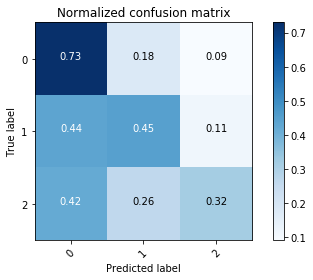

In [114]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
class_names = ['0','1','2']
cnf_matrix = confusion_matrix(y_test, y_predict)

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
